# Foundation Models

The previous notebook trained a classifier network which did only ok.  But what if we didn't have a lot of data?  In this notebook, we'll apply that model in a new way with _representation learning_.

In [1]:
import torch, torchvision


import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP


Here's the Convolutional Neural Network Again:

In [2]:
from torch import nn

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        # Two more convolutions:
        self.conv2 = torch.nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1)

        self.conv3 = torch.nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = nn.functional.layer_norm(x, x.shape)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_output):
        super(Classifier, self).__init__()


        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = torch.nn.Conv2d(in_channels=3,
                                    out_channels=32,
                                    kernel_size=4,
                                    stride=4)
        
        # Apply a series of convolutional blocks:
        self.conv_block_1 = torch.nn.Sequential(
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,)
        )

        # Downsample the outputs:
        self.downsample = torch.nn.Conv2d(in_channels=32, out_channels=64, 
                                          kernel_size=2, stride=2)

        # Apply another series of convolutional blocks:
        self.conv_block_2 = torch.nn.Sequential(
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,)
        )

        # This brings it down to one channel / class
        self.n_output = n_output
        self.bottleneck = torch.nn.Conv2d(in_channels=64, out_channels=self.n_output, 
                                          kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = torch.nn.functional.layer_norm(x, x.shape)

        x = self.conv_block_1(x)

        # Apply a normalization before downsampling:
        x = torch.nn.functional.layer_norm(x, x.shape)
        x = self.downsample(x)

        x = self.conv_block_2(x)


        x = self.bottleneck(x)

        # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,self.n_output))

In [3]:
model = Classifier(256)

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


NameError: name 'batch_size' is not defined

This will download the data if needed:

In [4]:
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified



We're going to train this on Polaris nodes which have 4 A100s (But only using one node at a time).  So, the following helper functions will automatically distribute the code and model to use all 4 GPUs at once:

(They are all from the [DDP Tutorial](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) )

In [5]:

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [6]:
def create_data_loaders(transforms, batch_size, rank):
    # Start up the data loader:
    dev = torch.device(
        f"cuda:{rank}") if torch.cuda.is_available() else torch.device("cpu")

    training_data = torchvision.datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms
    )
    
    test_data = torchvision.datasets.CIFAR10(
        root="data",
        train=False,
        download=True,
        transform=transforms
    )
    
    training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))
    
    
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=False)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
    

    def preprocess(x, y):
        # CIFAR-10 is *color* images so 3 layers!
        return x.view(-1, 3, 32, 32).to(dev), y.to(dev)
    
    
    class WrappedDataLoader:
        def __init__(self, dl, func):
            self.dl = dl
            self.func = func
    
        def __len__(self):
            return len(self.dl)
    
        def __iter__(self):
            for b in self.dl:
                yield (self.func(*b))


    train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
    val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

    return train_dataloader, val_dataloader

In [7]:


def demo_basic(rank, world_size, n_epochs):
    print(f"Running basic DDP example on rank {rank}.")
    setup(rank, world_size)

    
    # create model and move it to GPU with id rank
    model = ToyModel().to(rank)
    ddp_model = DDP(model, device_ids=[rank])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(rank)
    loss_fn(outputs, labels).backward()
    optimizer.step()

    cleanup()


def run_demo(demo_fn, world_size):
    mp.spawn(demo_fn,
             args=(world_size,5),
             nprocs=world_size,
             join=True)

In [8]:
import sys, os
from multiprocessing import Pool
from multiprocessing.reduction import ForkingPickler
from types import FunctionType
import cloudpickle

assert sys.version_info >= (3, 8), 'python3.8 or greater required to use reducer_override'

def reducer_override(obj):
    if type(obj) is FunctionType:
        return (cloudpickle.loads, (cloudpickle.dumps(obj),))
    else:
        return NotImplemented

# Monkeypatch our function reducer into the pickler for multiprocessing.
# Without this line, the main block will not work on windows or macOS.
# Alterntively, moving the defintionn of foo outside of the if statement
# would make the main block work on windows or macOS (when run from
# the command line).
ForkingPickler.reducer_override = staticmethod(reducer_override)

ModuleNotFoundError: No module named 'cloudpickle'

In [9]:
run_demo(demo_basic, 1)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'demo_basic' on <module '__main__' (built-in)>


ProcessExitedException: process 0 terminated with exit code 1

In [10]:
from torchvision import transforms


# This method is from the pytorch implementation of SimCLR:
# https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py

def get_simclr_pipeline_transform(size, s=1):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    data_transforms = transforms.Compose([
                                          transforms.RandomResizedCrop(size=size, scale=[0.85,1.0]),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomApply([color_jitter], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.ToTensor()])
    return data_transforms

In [11]:
transforms1 = get_simclr_pipeline_transform((32,32))
transforms2 = get_simclr_pipeline_transform((32,32))

In [12]:
train1, val1 = create_data_loaders(transforms1, 128, 0)
train2, val2 = create_data_loaders(transforms2, 128, 0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
batch, (X1, Y1) = next(enumerate(train1))
batch, (X2, Y2) = next(enumerate(train2))


In [14]:
from matplotlib import pyplot as plt

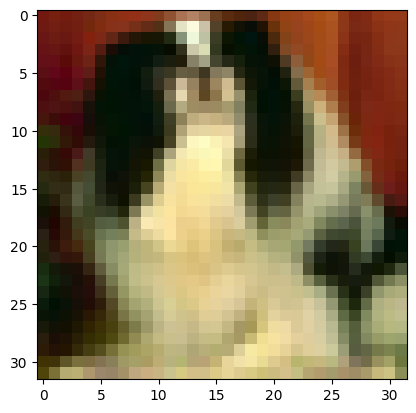

In [15]:
plt.imshow(X1[0].cpu().permute((1,2,0)))


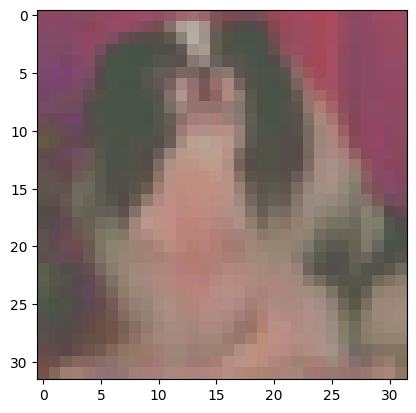

In [17]:
plt.imshow(X2[0].cpu().permute((1,2,0)))

In [113]:
def forward(net, X1, X2):

    rep1 = net(X1)
    rep2 = net(X2)

    return rep1, rep2

def contrastive_loss(first_images, second_images, rank, world_size = 1, temperature=0.1):
        # Each image is represented with k parameters,
        # Assume the batch size is N, so the
        # inputs have shape (N, k)

        # These are pre-distributed shapes:
        N = first_images.shape[0]
        k = first_images.shape[1]


        first_images = first_images / torch.norm(first_images,dim=1).reshape((-1,1))
        second_images = second_images / torch.norm(second_images,dim=1).reshape((-1,1))

        # Take the two tuples, and concatenate them.
        # Then, reshape into Y = (1, 2N, k) and Z = (2N, 1, k)

        c = torch.concat([first_images, second_images], dim=0)

        # Gather all the c up if the world size > 1:
        if world_size > 1:
            gathered_c = torch.distributed.all_gather(tensor=c)
            gathered_c = gathered_c.reshape((-1, first_images.shape[-1]))
        else:
            gathered_c = c

        # Each rank computes only a slice of the global loss matrix, or
        # the memory usage gets out of control.

        # We calculate the dot product between the local and global tensors:
        local_reps = c.reshape((c.shape[0], 1, c.shape[1]))
        all_reps   = gathered_c.reshape((1, gathered_c.shape[0], gathered_c.shape[1]))


        # Assume we have n images per rank, for N global images with N = n * world_size
        # Compute the product of these tensors, which gives shape
        # (2n, 2N, k)
        mat =  local_reps*all_reps

        # We need to compute the function (sim(x,y)) for each element in the 2N sequent.
        # Since the are normalized, we're computing x^T . Y / (||x||*||y||),
        # but the norms are equal to 1.
        # So, summing the matrix over the dim = 0 and dim = 1 computes this for each pair.

        sim = torch.sum(mat, dim=-1) / temperature



        # Now, sim is of shape [2*n, 2*N]

        # This yields a symmetric matrix, diagonal entries equal 1.  Off diagonal are symmetrics and < 1.

        # sim = torch.exp(sim / temperature)
        # Now, for every entry i in C (concat of both batches), the sum of sim[i] - sim[i][i] is the denominator

        device = sim.device

        # Since we have a non-symmetric matrix, need to build a non-symmetric index:
        positive = torch.zeros(sim.shape, device=device)

        # We concatenated all the local examples, and compute symmetric positive pairs
        # So for the first N entries, the index of the positive pair is i + N  (locally)
        # For the second N entries, the index of the positive pair is i - N (locally)
        # with a distributed run, we've squashed all the similarity scores together.
        # to a shape of [2*N, 2*N*Size]
        # Each 2*N by 2*N block is the local positive indexes, all others are negative.
        # That means that the index is shifted by global_rank*2*N

        access_index_x = torch.arange(2*N)
        # For the first N, the y-index is equal to x + 2*N
        # For the second N
        access_index_y = torch.arange(2*N)
        # Shift by +/- N:
        access_index_y[0:N] = access_index_y[0:N] + N
        access_index_y[N:]  = access_index_y[N:] - N

        access_index_y +=  rank * 2*N

        # print("access_index_y: ", access_index_y, flush=True)

        positive[access_index_x, access_index_y] = 1

        # For the negative, we invert the positive and have to 0 out the self-index entries
        negative = 1 - positive

        # THESE WORK IF IT'S NOT DISTRIBUTED
        # positive = torch.tile(torch.eye(N, device=device), (2,2))
        # # Unsure if this line is needed?
        # positive = positive - torch.eye(2*N, device=device)
        #
        # negative = - (torch.eye(2*N, device=device) - 1)

        with torch.no_grad():
            # Here, we can compute the top-k metrics for this batch, since we have the global state:
            # We want the top 5 entries but the self-sim is obviously perfect.
            # So take the top 6 and reject the first.
            topk = torch.topk(sim, k=6, dim=-1, sorted=True)

            # Top 1 is just an equality check:
            top1_acc = topk.indices[:,1] == access_index_y.to(topk.indices.device)
            top1_acc = torch.mean(top1_acc.to(torch.float))
          
            # Top 5 is a little more complicated:
            # Compute the index distance to the correct index, abs value:
            top5_acc_dist = torch.abs(topk.indices[:,1:] - access_index_y.to(topk.indices.device).reshape(-1,1))
            # Get the minumum value, and see if it is less than 5:
            min_values, _ = torch.min(top5_acc_dist, dim=-1)
            top5_acc =  min_values < 5.
            # Average over the batch dimension:
            top5_acc = torch.mean(top5_acc.to(torch.float))


        negative_examples = sim * negative
        positive_examples = sim * positive

        # Now, positive/negative examples is the temperature normalized similarity.
        # we need to sum across the whole batch dimension to compute it per-example:


        # Compute the alignment, summed over the entire global batch:
        alignment = torch.sum(positive_examples, dim=-1)

        # Compute the exp, which we'll eventually sum and log:
        exp = torch.sum(torch.exp(negative_examples), dim=-1)

        # print("Alignment: ", alignment, flush=True)
        # print("exp: ",       exp, flush=True)


        # And compute the logsumexp of the negative examples:
        log_sum_exp = torch.log(exp )


        # Additionally, we can compute the "floor" of the loss at this batch size:
        # floor = torch.log(1.*N) - 1.

        loss_metrics = {
            "alignment"   : torch.mean(alignment),
            "log_sum_exp" : torch.mean(log_sum_exp),
            "top1"        : top1_acc,
            "top5"        : top5_acc,
            # "floor"       : floor,
        }

        loss = torch.mean( - alignment + log_sum_exp)
        return loss, loss_metrics


In [114]:
rep1, rep2 = forward(model, X1, X2)
print(rep1.shape)

torch.Size([128, 256])


In [117]:
loss, metrics = contrastive_loss(rep1, rep2, 0)

In [119]:
loss.backward()

In [120]:
model

Classifier(
  (stem): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
  (conv_block_1): Sequential(
    (0): ConvNextBlock(
      (conv1): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=32)
      (conv2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ConvNextBlock(
      (conv1): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=32)
      (conv2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): ConvNextBlock(
      (conv1): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=32)
      (conv2): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ConvNextBlock(
      (conv1): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1), padding=same, groups=32)
      (conv2): Conv2d(128, 3